# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第20节 A股全市场回测</b></font>
</center>

-----------------

作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

在第19节‘数据源’中分别获取了各个市场的6年交易数据，本节将做A股市场全市场回测。

首先导入abupy中本节使用的模块：

In [1]:
# 基础库导入
from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/df_kl.h5


In [2]:
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import abu, EMarketTargetType, AbuMetricsBase, ABuMarketDrawing, ABuProgress, ABuSymbolPd
from abupy import EMarketTargetType, EDataCacheType, EMarketSourceType, EMarketDataFetchMode, EStoreAbu, AbuUmpMainMul
from abupy import AbuUmpMainDeg, AbuUmpMainJump, AbuUmpMainPrice, AbuUmpMainWave, feature, AbuFeatureDegExtend
from abupy import AbuUmpEdgeDeg, AbuUmpEdgePrice, AbuUmpEdgeWave, AbuUmpEdgeFull, AbuUmpEdgeMul, AbuUmpEegeDegExtend
from abupy import AbuUmpMainDegExtend, ump
# 关闭沙盒数据
abupy.env.disable_example_env_ipython()

disable example env


所有数据已存放在百度云盘上，后面的章节使用的数据都是本节更新的数据，建议直接从云盘下载入库完毕的数据库，不需要从各个数据源再一个一个的下载数据进行入库，百度云地址如下：

[csv格式美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1geNZgqf) 密码: gvtr

下面的数据存贮格式为hdf5数据，由于hdf5文件解压后非常大，还需要区分python版本，所以如果没有足够的存贮空间
特别是python2下，建议使用csv格式的缓存文件：

[mac系统python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1o8sldNk) 密码: ecyp

[mac系统python2 A股6年日k数据: ](https://pan.baidu.com/s/1bptn25h) 密码: sid8

[windows python3 美股，A股，港股，币类，期货6年日k数据](https://pan.baidu.com/s/1bzeVHO) 密码: 3cwe

[windows python2 A股6年日k数据: ](https://pan.baidu.com/s/1skZOe7N) 密码: 78mb

下载完毕上述数据后，hdf5解压得到df_kl.h5文件，csv解压得到csv文件夹，解压后放到下面路径下即可

In [ ]:
if abupy.env.g_is_mac_os:
    !open $abupy.env.g_project_data_dir
else:
    !echo $abupy.env.g_project_data_dir

如果不想通过直接下载数据文件的方式，也可运行下面的cell点击按钮后进行A股数据全市场更新，如果运行过就不要重复运行了：

In [3]:
def bd_cn():
    abupy.env.g_market_source = EMarketSourceType.E_MARKET_SOURCE_bd
    abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV
    abu.run_kl_update(start='2011-08-08', end='2017-08-08', market=EMarketTargetType.E_MARKET_TARGET_CN, n_jobs=32)

import ipywidgets
# 避免使用notebook运行run all时运行不想执行的代码
_ = ipywidgets.interact_manual(bd_cn)

买入因子，卖出因子等依然使用相同的设置，如下所示：

In [4]:
# 初始化资金500万
read_cash = 5000000

# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]

# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN
abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL

### 1. A股交易训练集回测

下面将回测市场设置为A股市场：

In [3]:
abupy.env.g_market_target = EMarketTargetType.E_MARKET_TARGET_CN

将数据读取模式设置为本地数据模式，即进行全市场回测时最合适的模式，运行效率高，且分类数据更新和交易回测。

In [4]:
abupy.env.g_data_fetch_mode = EMarketDataFetchMode.E_DATA_FETCH_FORCE_LOCAL

下面根据下载的数据缓存类型设置缓存类型，如果下载解压的是csv需要勾选use_csv，如果是hdf5不需要勾选：

In [5]:
def select_store_cache(use_csv):
    if use_csv:
        abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_CSV
    else:
        abupy.env.g_data_cache_type = EDataCacheType.E_DATA_CACHE_HDF5
    print(abupy.env.g_data_cache_type)
        
use_csv = ipywidgets.Checkbox(True)
_ = ipywidgets.interact(select_store_cache, use_csv=use_csv)

EDataCacheType.E_DATA_CACHE_HDF5


下面通过env中的设置将回测中的symbols切分为回测训练集与回测测试集，且打开回测生成买入时刻特征开关：

详情请查询ABuMarket模块

In [8]:
# 回测生成买入时刻特征
abupy.env.g_enable_ml_feature = True
# 回测开始时将symbols切割分为训练集数据和测试集两份，使用训练集进行回测
abupy.env.g_enable_train_test_split = True

上面切割训练集，测试集使用的切割比例参数默认为10，即切割为10份，9份做为训练，1份做为测试，也可自定义切割比例，在之后的章节示例

资金管理依然使用默认atr，每笔交易的买入基数资金设置为万分之30，这个值如果设置太大，比如初始默认的0.1的话，将会导致太多的股票由于资金不足无法买入，丧失全市场回测的意义，如果太小的话又会导致资金利用率下降，导致最终收益下降：

更多资金管理请阅读相关源代码或《量化交易之路》中相关内容

In [9]:
# 每笔交易的买入基数资金设置为万分之30
abupy.beta.atr.g_atr_pos_base = 0.003

下面添加‘第18节 自定义裁判决策交易‘中示例编写的10，30，50，90，120日走势拟合角度特征AbuFeatureDegExtend，做为回测时的新的视角来录制比赛（记录回测特征）

In [10]:
feature.clear_user_feature()
feature.append_user_feature(AbuFeatureDegExtend)

在上面run_kl_update中更新了从2011-08-08至2017-08-08，由于在买入时刻生成特征，所以要保留一年的数据做为特征数据回测时段，所以下面的回测start使用2012-08-08至2017-08-08，即向后推了一年做回测：

下面开始回测，第一次运行select：run loop back，然后点击run select，如果已经回测过可select：load train data直接从缓存数据读取：

In [ ]:
abu_result_tuple = None
def run_loop_back():
    global abu_result_tuple
    abu_result_tuple, _ = abu.run_loop_back(read_cash,
                                            buy_factors,
                                            sell_factors,
                                            choice_symbols=None,
                                            start='2012-08-08', end='2017-08-08')
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='train_cn')
    ABuProgress.clear_output()

def run_load_train():
    global abu_result_tuple
    abu_result_tuple = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='train_cn')

def select(select):
    if select == 'run loop back':
        run_loop_back()
    else:
        run_load_train()

_ = ipywidgets.interact_manual(select, select=['run loop back', 'load train data'])

买入后卖出的交易数量:55224
买入后尚未卖出的交易数量:951
胜率:47.1353%
平均获利期望:16.5030%
平均亏损期望:-7.7784%
盈亏比:1.9844
策略收益: 111.4373%
基准收益: 52.5454%
策略年化收益: 23.1320%
基准年化收益: 10.9073%
策略买入成交比例:31.0939%
策略资金利用率比例:75.5849%
策略共执行1214个交易日


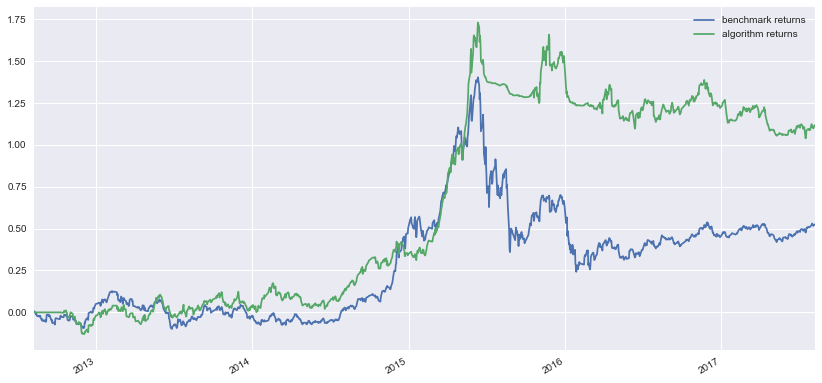

In [39]:
AbuMetricsBase.show_general(*abu_result_tuple, only_show_returns=True)

### 2. A股交易测试集回测

下面通过env中设置使用刚才切分的测试集美股symbol，它使用pickle读取之前已经切割好的本地化测试集股票代码序列：

In [45]:
# 测试集回测时依然生成买入时刻特征
abupy.env.g_enable_ml_feature = True
# 回测时不重新切割训练集数据和测试集
abupy.env.g_enable_train_test_split = False
# 回测时使用切割好的测试数据
abupy.env.g_enable_last_split_test = True


# 测试集依然使用10，30，50，90，120日走势拟合角度特征AbuFeatureDegExtend，做为回测时的新的视角来录制比赛（记录回测特征）
feature.clear_user_feature()
feature.append_user_feature(AbuFeatureDegExtend)

提高g_atr_pos_base为0.025（因为默认切割训练集与测试集数据比例为9:1，所以提高g_atr_pos_base为之前的大概8-10倍都可以：

In [41]:
abupy.beta.atr.g_atr_pos_base = 0.025

下面开始测试集回测，同训练集第一次运行select：run loop back，然后点击run select，如果已经回测过可select：load train data直接从缓存数据读取：

In [42]:
abu_result_tuple_test = None
def run_loop_back_test():
    global abu_result_tuple_test
    abu_result_tuple_test, _ = abu.run_loop_back(read_cash,
                                                 buy_factors,
                                                 sell_factors,
                                                 choice_symbols=None,
                                                 start='2012-08-08', end='2017-08-08')
    # 把运行的结果保存在本地，以便之后分析回测使用，保存回测结果数据代码如下所示
    abu.store_abu_result_tuple(abu_result_tuple_test, n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                               custom_name='test_cn')
    ABuProgress.clear_output()

def run_load_test():
    global abu_result_tuple_test
    abu_result_tuple_test = abu.load_abu_result_tuple(n_folds=5, store_type=EStoreAbu.E_STORE_CUSTOM_NAME, 
                                                 custom_name='test_cn')

def select_test(select):
    if select == 'run loop back':
        run_loop_back_test()
    else:
        run_load_test()

_ = ipywidgets.interact_manual(select_test, select=['run loop back', 'load test data'])

please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_cn_capital
please wait! load_pickle....: /Users/Bailey/abu/data/cache/n5_test_cn_benchmark


买入后卖出的交易数量:6321
买入后尚未卖出的交易数量:124
胜率:47.6507%
平均获利期望:15.7211%
平均亏损期望:-7.6456%
盈亏比:2.0477
策略收益: 102.4382%
基准收益: 52.5454%
策略年化收益: 21.2639%
基准年化收益: 10.9073%
策略买入成交比例:26.2064%
策略资金利用率比例:73.9138%
策略共执行1214个交易日


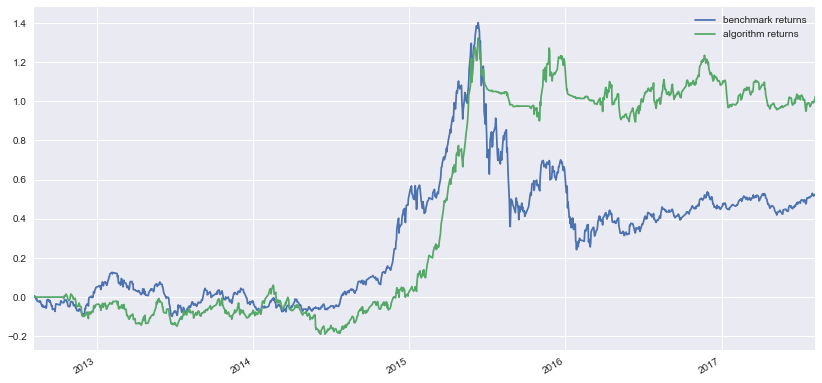

In [43]:
AbuMetricsBase.show_general(*abu_result_tuple_test, only_show_returns=True)

小结：本节所有操作都非常耗时，特别是在cpu不够快的电脑上，建议睡觉的时候运行哈，下一节将使用本节回测好的数据进行ump训练优化示例。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html)

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)